Copyright (c) 2022, Hikmet Güner
All rights reserved.

This source code is licensed under the BSD-style license found in the
LICENSE file in the root directory of this source tree. 

<h1>Imports</h1>

In [236]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist


<h2>Reading and Analyzing Data</h2>

In [237]:
plot_colors = [(np.random.random(), np.random.random(), np.random.random()) for i in range(40)]
pd.set_option('mode.chained_assignment', None)
df = pd.read_csv("exoplanets.csv",header=0, index_col=0)
df.head(10)

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,...,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
0,11 Com b,11 Com,1,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2014-05-14,2008-01,2014-05-14
1,11 Com b,11 Com,0,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2014-07-23,2011-08,2014-07-23
2,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-04-25,2011-08,2014-07-23
3,11 UMi b,11 UMi,1,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-09-04,2017-03,2018-09-06
4,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-04-25,2009-10,2014-05-14
5,14 And b,14 And,0,1,1,Radial Velocity,2008,Okayama Astrophysical Observatory,Published Confirmed,0,...,-0.023,2.331,0.240,-0.240,4.91781,0.002826,-0.002826,2014-07-23,2011-08,2014-07-23
6,14 And b,14 And,1,1,1,Radial Velocity,2008,Okayama Astrophysical Observatory,Published Confirmed,0,...,-0.023,2.331,0.240,-0.240,4.91781,0.002826,-0.002826,2014-05-14,2008-12,2014-05-14
7,14 Her b,14 Her,0,1,2,Radial Velocity,2002,W. M. Keck Observatory,Published Confirmed,0,...,-0.023,4.714,0.016,-0.016,6.38300,0.000351,-0.000351,2021-09-20,2021-05,2021-09-20
8,14 Her b,14 Her,0,1,2,Radial Velocity,2002,W. M. Keck Observatory,Published Confirmed,0,...,-0.023,4.714,0.016,-0.016,6.38300,0.000351,-0.000351,2018-04-25,2003-01,2014-08-21
9,14 Her b,14 Her,0,1,2,Radial Velocity,2002,W. M. Keck Observatory,Published Confirmed,0,...,-0.023,4.714,0.016,-0.016,6.38300,0.000351,-0.000351,2018-04-25,2008-04,2014-08-21


<h2>Checking Null Values</h2>

Calculating total amount of null values for insight, preparing for what's to come.

In [238]:
total_null_values = df.isnull().sum().sum()
total_null_values

916679

Dealing with rows with many missing data

In [239]:
def get_empty_col(row_index):
    total_nan = 0
    for col in df.columns:
        if pd.isna(df[col][row_index]):
            total_nan += 1
    return total_nan

Finding duplicate entries

In [240]:
df['empty_col_count'] = 0
for i in df.index:
    df['empty_col_count'][i] = get_empty_col(i)
df.head(10)

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,...,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate,empty_col_count
0,11 Com b,11 Com,1,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2014-05-14,2008-01,2014-05-14,16
1,11 Com b,11 Com,0,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2014-07-23,2011-08,2014-07-23,42
2,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-04-25,2011-08,2014-07-23,42
3,11 UMi b,11 UMi,1,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-09-04,2017-03,2018-09-06,19
4,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-04-25,2009-10,2014-05-14,16
5,14 And b,14 And,0,1,1,Radial Velocity,2008,Okayama Astrophysical Observatory,Published Confirmed,0,...,2.331,0.240,-0.240,4.91781,0.002826,-0.002826,2014-07-23,2011-08,2014-07-23,42
6,14 And b,14 And,1,1,1,Radial Velocity,2008,Okayama Astrophysical Observatory,Published Confirmed,0,...,2.331,0.240,-0.240,4.91781,0.002826,-0.002826,2014-05-14,2008-12,2014-05-14,24
7,14 Her b,14 Her,0,1,2,Radial Velocity,2002,W. M. Keck Observatory,Published Confirmed,0,...,4.714,0.016,-0.016,6.38300,0.000351,-0.000351,2021-09-20,2021-05,2021-09-20,17
8,14 Her b,14 Her,0,1,2,Radial Velocity,2002,W. M. Keck Observatory,Published Confirmed,0,...,4.714,0.016,-0.016,6.38300,0.000351,-0.000351,2018-04-25,2003-01,2014-08-21,38
9,14 Her b,14 Her,0,1,2,Radial Velocity,2002,W. M. Keck Observatory,Published Confirmed,0,...,4.714,0.016,-0.016,6.38300,0.000351,-0.000351,2018-04-25,2008-04,2014-08-21,27


Dropping rows after sorting by update year and empty column number

In [241]:
df = df.sort_values(['empty_col_count','rowupdate'], ascending=[True,True]).drop_duplicates('pl_name').sort_index()

In [242]:
df.head(20)

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,...,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate,empty_col_count
0,11 Com b,11 Com,1,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,2.282000,0.346,-0.346,4.44038,0.003848,-0.003848,2014-05-14,2008-01,2014-05-14,16
4,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,1.939000,0.270,-0.270,4.56216,0.003903,-0.003903,2018-04-25,2009-10,2014-05-14,16
6,14 And b,14 And,1,1,1,Radial Velocity,2008,Okayama Astrophysical Observatory,Published Confirmed,0,...,2.331000,0.240,-0.240,4.91781,0.002826,-0.002826,2014-05-14,2008-12,2014-05-14,24
7,14 Her b,14 Her,0,1,2,Radial Velocity,2002,W. M. Keck Observatory,Published Confirmed,0,...,4.714000,0.016,-0.016,6.38300,0.000351,-0.000351,2021-09-20,2021-05,2021-09-20,17
19,16 Cyg B b,16 Cyg B,0,3,1,Radial Velocity,1996,Multiple Observatories,Published Confirmed,0,...,4.651000,0.016,-0.016,6.06428,0.000603,-0.000603,2018-04-25,2007-09,2014-09-18,17
20,17 Sco b,17 Sco,1,1,1,Radial Velocity,2020,Lick Observatory,Published Confirmed,0,...,2.094000,0.244,-0.244,4.75429,0.005055,-0.005055,2021-10-25,2020-12,2021-10-25,16
21,18 Del b,18 Del,1,2,1,Radial Velocity,2008,Okayama Astrophysical Observatory,Published Confirmed,0,...,3.366000,0.204,-0.204,5.27476,0.002654,-0.002654,2014-05-14,2008-06,2014-05-14,26
25,1RXS J160929.1-210524 b,1RXS J160929.1-210524,0,1,1,Imaging,2008,Gemini Observatory,Published Confirmed,0,...,8.916000,0.021,-0.021,12.05720,0.002275,-0.002275,2015-04-01,2010-08,2015-04-01,28
27,24 Boo b,24 Boo,1,1,1,Radial Velocity,2018,Okayama Astrophysical Observatory,Published Confirmed,0,...,3.159000,0.280,-0.280,5.33390,0.002000,-0.002000,2018-04-25,2018-08,2018-04-26,16
28,24 Sex b,24 Sex,1,1,2,Radial Velocity,2010,Lick Observatory,Published Confirmed,0,...,4.285000,0.016,-0.016,6.20374,0.000498,-0.000498,2014-05-14,2011-01,2014-05-14,17


Checking how it compares to the amount of rows 

In [243]:
print(df['empty_col_count'].max())
print(df['empty_col_count'].min())
print(len(df.columns))

61
0
93


Dropping rows missing over %50 columns

In [244]:
print(len(df.index))
df = df[df['empty_col_count'] < 50]
len(df.index)

5044


4931

Iterating over columns to find the ratio of null values to total values.
If the ratio is greater than 0.7, the column will be dropped.

In [245]:
drop_columns = []
for name, val in df.items():
    na_ratio =  val.isnull().sum() / len(val)
    if(na_ratio > 0.7):
        print(f"{name:<16} {na_ratio*100:.3f}%")
        drop_columns.append(name)

pl_radjerr1      70.047%
pl_radjerr2      70.047%
pl_orbeccenerr1  75.360%
pl_orbeccenerr2  75.360%
pl_eqterr1       78.402%
pl_eqterr2       78.402%
st_spectype      78.077%


Adding the columns that are not useful for the model to the drop columns list

In [246]:
drop_columns.extend([
    'default_flag',
    'discoverymethod',
    'disc_year',
    'disc_facility',
    'soltype',
    'pl_controv_flag',
    'pl_refname',
    'sy_refname',
    'st_refname',
    'rastr',
    'ra',
    'decstr',
    'dec',
    'st_metratio',
    'pl_pubdate',
    'releasedate',
    'pl_radjlim',
    'pl_bmassprov',
    'pl_bmasselim',
    'pl_bmassjlim',
    'pl_orbperlim',
    'pl_orbsmaxlim',
    'pl_radelim',
    'pl_orbeccenlim',
    'pl_insollim',
    'pl_eqtlim',
    'st_tefflim',
    'st_radlim',
    'st_masslim',
    'st_metlim',
    'st_metratio',
    'st_logglim',
    'pl_bmasseerr2',
    'pl_bmassjerr2',
    'pl_orbsmaxerr2',
    'st_tefferr2',
    'st_raderr2',
    'st_masserr2',
    'st_meterr2',
    'st_loggerr2',
    'sy_vmagerr2',
    'sy_kmagerr2',
    'sy_gaiamagerr2',
    'pl_radeerr2',
    'pl_orbpererr2',
    'pl_insolerr2',
    'sy_disterr2'
    ])


Dropping columns that are related to the parent star, the data could be used for another analysis on how to detect stars that might have habitable planets within their systems.

In [247]:
index = 0
for columns in drop_columns:
    if index % 7 == 0:
        print()
    print(f'{columns:<20}', end='')
    index += 1


pl_radjerr1         pl_radjerr2         pl_orbeccenerr1     pl_orbeccenerr2     pl_eqterr1          pl_eqterr2          st_spectype         
default_flag        discoverymethod     disc_year           disc_facility       soltype             pl_controv_flag     pl_refname          
sy_refname          st_refname          rastr               ra                  decstr              dec                 st_metratio         
pl_pubdate          releasedate         pl_radjlim          pl_bmassprov        pl_bmasselim        pl_bmassjlim        pl_orbperlim        
pl_orbsmaxlim       pl_radelim          pl_orbeccenlim      pl_insollim         pl_eqtlim           st_tefflim          st_radlim           
st_masslim          st_metlim           st_metratio         st_logglim          pl_bmasseerr2       pl_bmassjerr2       pl_orbsmaxerr2      
st_tefferr2         st_raderr2          st_masserr2         st_meterr2          st_loggerr2         sy_vmagerr2         sy_kmagerr2         
sy_gaiamager

Dropping columns from the dataset

In [248]:
df = df.drop(columns=drop_columns)
df.head(10)

,pl_name,hostname,sy_snum,sy_pnum,pl_orbper,pl_orbpererr1,pl_orbsmax,pl_orbsmaxerr1,pl_rade,pl_radeerr1,...,sy_dist,sy_disterr1,sy_vmag,sy_vmagerr1,sy_kmag,sy_kmagerr1,sy_gaiamag,sy_gaiamagerr1,rowupdate,empty_col_count
0,11 Com b,11 Com,2,1,326.0300,0.3200,1.290,0.050,NaN,NaN,...,93.1846,1.92380,4.72307,0.023,2.282,0.346,4.44038,0.003848,2014-05-14,16
4,11 UMi b,11 UMi,1,1,516.2200,3.2500,1.540,0.070,NaN,NaN,...,125.3210,1.97650,5.01300,0.005,1.939,0.270,4.56216,0.003903,2018-04-25,16
6,14 And b,14 And,1,1,185.8400,0.2300,0.830,NaN,NaN,NaN,...,75.4392,0.71400,5.23133,0.023,2.331,0.240,4.91781,0.002826,2014-05-14,24
7,14 Her b,14 Her,1,2,1766.4100,0.6700,2.830,0.041,NaN,NaN,...,17.9323,0.00730,6.61935,0.023,4.714,0.016,6.38300,0.000351,2021-09-20,17
19,16 Cyg B b,16 Cyg B,3,1,799.5000,0.6000,1.680,0.030,NaN,NaN,...,21.1397,0.01100,6.21500,0.016,4.651,0.016,6.06428,0.000603,2018-04-25,17
20,17 Sco b,17 Sco,1,1,578.3800,2.0100,1.450,0.020,NaN,NaN,...,124.9530,2.59000,5.22606,0.023,2.094,0.244,4.75429,0.005055,2021-10-25,16
21,18 Del b,18 Del,2,1,993.3000,3.2000,2.600,NaN,NaN,NaN,...,76.2220,0.62170,5.51048,0.023,3.366,0.204,5.27476,0.002654,2014-05-14,26
25,1RXS J160929.1-210524 b,1RXS J160929.1-210524,1,1,NaN,NaN,330.000,NaN,NaN,NaN,...,139.1350,1.33200,12.61800,0.069,8.916,0.021,12.05720,0.002275,2015-04-01,28
27,24 Boo b,24 Boo,1,1,30.3506,0.0078,0.190,0.012,NaN,NaN,...,95.9863,0.63685,5.59000,0.001,3.159,0.280,5.33390,0.002000,2018-04-25,16
28,24 Sex b,24 Sex,1,2,452.8000,2.1000,1.333,0.004,NaN,NaN,...,72.0691,0.68540,6.45350,0.023,4.285,0.016,6.20374,0.000498,2014-05-14,17


In [249]:
null_after_dropcol = df.isnull().sum().sum()
null_after_dropcol

30563

Function for finding amount of missing columns for a row

In [250]:
df.head(10)

,pl_name,hostname,sy_snum,sy_pnum,pl_orbper,pl_orbpererr1,pl_orbsmax,pl_orbsmaxerr1,pl_rade,pl_radeerr1,...,sy_dist,sy_disterr1,sy_vmag,sy_vmagerr1,sy_kmag,sy_kmagerr1,sy_gaiamag,sy_gaiamagerr1,rowupdate,empty_col_count
0,11 Com b,11 Com,2,1,326.0300,0.3200,1.290,0.050,NaN,NaN,...,93.1846,1.92380,4.72307,0.023,2.282,0.346,4.44038,0.003848,2014-05-14,16
4,11 UMi b,11 UMi,1,1,516.2200,3.2500,1.540,0.070,NaN,NaN,...,125.3210,1.97650,5.01300,0.005,1.939,0.270,4.56216,0.003903,2018-04-25,16
6,14 And b,14 And,1,1,185.8400,0.2300,0.830,NaN,NaN,NaN,...,75.4392,0.71400,5.23133,0.023,2.331,0.240,4.91781,0.002826,2014-05-14,24
7,14 Her b,14 Her,1,2,1766.4100,0.6700,2.830,0.041,NaN,NaN,...,17.9323,0.00730,6.61935,0.023,4.714,0.016,6.38300,0.000351,2021-09-20,17
19,16 Cyg B b,16 Cyg B,3,1,799.5000,0.6000,1.680,0.030,NaN,NaN,...,21.1397,0.01100,6.21500,0.016,4.651,0.016,6.06428,0.000603,2018-04-25,17
20,17 Sco b,17 Sco,1,1,578.3800,2.0100,1.450,0.020,NaN,NaN,...,124.9530,2.59000,5.22606,0.023,2.094,0.244,4.75429,0.005055,2021-10-25,16
21,18 Del b,18 Del,2,1,993.3000,3.2000,2.600,NaN,NaN,NaN,...,76.2220,0.62170,5.51048,0.023,3.366,0.204,5.27476,0.002654,2014-05-14,26
25,1RXS J160929.1-210524 b,1RXS J160929.1-210524,1,1,NaN,NaN,330.000,NaN,NaN,NaN,...,139.1350,1.33200,12.61800,0.069,8.916,0.021,12.05720,0.002275,2015-04-01,28
27,24 Boo b,24 Boo,1,1,30.3506,0.0078,0.190,0.012,NaN,NaN,...,95.9863,0.63685,5.59000,0.001,3.159,0.280,5.33390,0.002000,2018-04-25,16
28,24 Sex b,24 Sex,1,2,452.8000,2.1000,1.333,0.004,NaN,NaN,...,72.0691,0.68540,6.45350,0.023,4.285,0.016,6.20374,0.000498,2014-05-14,17


<h1>Filling Empty Columns</h1>

Checking for empty columns that miss under %30 of data

In [251]:
for name, val in df.items():
    na_ratio =  val.isnull().sum() / len(val)
    if na_ratio < 0.3 and na_ratio != 0:
        print(f"{name:<16} {na_ratio*100:.3f}%")

pl_orbper        1.318%
pl_orbpererr1    2.150%
pl_orbsmax       6.773%
pl_rade          20.402%
pl_radeerr1      20.503%
pl_orbeccen      14.723%
pl_eqt           27.966%
st_teff          2.778%
st_tefferr1      3.995%
st_rad           5.435%
st_raderr1       6.246%
st_mass          0.608%
st_masserr1      3.265%
st_met           7.260%
st_meterr1       9.876%
st_logg          7.017%
st_loggerr1      7.747%
sy_dist          2.190%
sy_disterr1      4.178%
sy_vmag          0.811%
sy_vmagerr1      0.872%
sy_kmag          0.852%
sy_kmagerr1      1.420%
sy_gaiamag       1.683%
sy_gaiamagerr1   1.683%
rowupdate        0.020%


Checking for empty columns that miss over %30 of data

In [252]:
for name, val in df.items():
    na_ratio =  val.isnull().sum() / len(val)
    if na_ratio > 0.3:
        print(f"{name:<16} {na_ratio*100:.3f}%")

pl_orbsmaxerr1   58.264%
pl_radj          69.945%
pl_bmasse        60.596%
pl_bmasseerr1    63.091%
pl_bmassj        60.596%
pl_bmassjerr1    63.111%
pl_insol         40.986%
pl_insolerr1     41.452%


<h3>There seems to be a lot of missing data, however, KNNImputer will be utilized to fill the empty columns.</h3>

Before scaling, check if each data is suitable for scaling

In [253]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4931 entries, 0 to 32551
Columns: 40 entries, pl_name to empty_col_count
dtypes: float64(33), int64(4), object(3)
memory usage: 1.5+ MB


In [254]:
object_col = df.select_dtypes(object)
object_col.value_counts()

pl_name       hostname    rowupdate 
11 Com b      11 Com      2014-05-14    1
Kepler-299 b  Kepler-299  2014-11-18    1
Kepler-300 b  Kepler-300  2014-11-18    1
Kepler-30 d   Kepler-30   2014-05-14    1
Kepler-30 c   Kepler-30   2014-05-14    1
                                       ..
KELT-21 b     KELT-21     2018-02-01    1
KELT-20 b     KELT-20     2019-12-02    1
KELT-2 A b    KELT-2 A    2019-03-18    1
KELT-19 A b   KELT-19 A   2018-01-08    1
xi Aql b      xi Aql      2014-05-14    1
Length: 4930, dtype: int64

In [255]:
label_df = df[['pl_name','hostname']]
df = df.drop(['pl_name','hostname','rowupdate','empty_col_count'], axis=1)
label_df.head()

,pl_name,hostname
0,11 Com b,11 Com
4,11 UMi b,11 UMi
6,14 And b,14 And
7,14 Her b,14 Her
19,16 Cyg B b,16 Cyg B


First, the data will be scaled for further use

In [256]:
scaler = MinMaxScaler()
df.apply(np.abs)
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns, index=df.index)
df.head(10)

,sy_snum,sy_pnum,pl_orbper,pl_orbpererr1,pl_orbsmax,pl_orbsmaxerr1,pl_rade,pl_radeerr1,pl_radj,pl_bmasse,...,st_logg,st_loggerr1,sy_dist,sy_disterr1,sy_vmag,sy_vmagerr1,sy_kmag,sy_kmagerr1,sy_gaiamag,sy_gaiamagerr1
0,0.333333,0.000000,8.105728e-07,6.808510e-10,0.000171,9.606148e-06,NaN,NaN,NaN,0.348966,...,0.177419,0.090909,0.010443,0.000517,0.094509,0.006569,0.169975,0.033554,0.087725,0.059038
4,0.000000,0.000000,1.283682e-06,6.914894e-09,0.000204,1.344861e-05,NaN,NaN,NaN,0.188874,...,0.073314,0.136364,0.014095,0.000531,0.101625,0.001194,0.159029,0.025942,0.094780,0.059919
6,0.000000,0.000000,4.618415e-07,4.893617e-10,0.000110,NaN,NaN,NaN,NaN,0.086341,...,0.224340,0.063636,0.008426,0.000192,0.106983,0.006569,0.171539,0.022937,0.115386,0.042849
7,0.000000,0.142857,4.393608e-06,1.425532e-09,0.000376,7.877041e-06,NaN,NaN,NaN,0.087244,...,0.488270,0.027273,0.001890,0.000002,0.141046,0.006569,0.247590,0.000501,0.200276,0.003632
19,0.666667,0.000000,1.988359e-06,1.276596e-09,0.000223,5.763689e-06,NaN,NaN,NaN,0.030219,...,0.476540,0.090909,0.002255,0.000003,0.131123,0.004479,0.245580,0.000501,0.181810,0.007620
20,0.000000,0.000000,1.438309e-06,4.276596e-09,0.000192,3.842459e-06,NaN,NaN,NaN,0.077710,...,0.087977,0.036364,0.014053,0.000696,0.106853,0.006569,0.163975,0.023337,0.105912,0.078165
21,0.333333,0.000000,2.470448e-06,6.808511e-09,0.000346,NaN,NaN,NaN,NaN,0.185276,...,0.252199,0.054545,0.008515,0.000167,0.113833,0.006569,0.204570,0.019331,0.136067,0.040119
25,0.000000,0.000000,NaN,NaN,0.043964,NaN,NaN,NaN,NaN,0.169796,...,0.425220,0.127273,0.015665,0.000358,0.288260,0.020305,0.381694,0.001002,0.529028,0.034115
27,0.000000,0.000000,7.505195e-08,1.659572e-11,0.000025,2.305476e-06,NaN,NaN,NaN,0.016369,...,0.193548,0.090909,0.010761,0.000171,0.115785,0.000000,0.197964,0.026943,0.139493,0.029754
28,0.000000,0.142857,1.125921e-06,4.468085e-09,0.000177,7.684918e-07,NaN,NaN,NaN,0.035795,...,0.351906,0.090909,0.008043,0.000184,0.136976,0.006569,0.233899,0.000501,0.189890,0.005952


Defining method to analyze columns after imputation

In [257]:
def get_col_info(col):
    if('err' in col or 'flag' in col):
        return
    mean = df[col].mean()
    std = df[col].std()
    col_max = df[col].max()
    col_min = df[col].min()
    sem = df[col].sem()
    pdf = stats.norm.pdf(df[col].sort_values(),mean,std)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
    print(type(axes))
    fig.suptitle(f'Distribution of {col}')
    #normalize plot
    axes[0].plot(df[col].sort_values(), pdf)
    axes[0].grid(True, alpha=0.3, linestyle="--")
    #box plot
    axes[1].boxplot(df[col].dropna(), showfliers=False)
    #text field
    axes[2].text(0.1,0.7,f'mean: {mean:.9f}',   bbox=dict(facecolor='cyan', alpha=0.4))
    axes[2].text(0.1,0.58,f'std: {std:.9f}',    bbox=dict(facecolor='magenta', alpha=0.4))
    axes[2].text(0.1,0.46,f'max: {col_max:.9f}',bbox=dict(facecolor='blue', alpha=0.4))
    axes[2].text(0.1,0.34,f'min: {col_min:.9f}',bbox=dict(facecolor='green', alpha=0.4))
    axes[2].text(0.1,0.22,f'err: {sem:.9f}',    bbox=dict(facecolor='red', alpha=0.6))
    axes[2].set_yticks([])
    axes[2].set_xticks([])
    fig.tight_layout()

In [258]:
def get_cols_info():
    n_col = 6
    fig, axes = plt.subplots(nrows=(len(df.columns) // n_col), ncols=n_col, figsize=(18,18))
    ax_index = 0
    fig.suptitle(f'Distribution of Columns Visualized')
    for col in df.columns:
        sample = df[col].sort_values()
        #attributes
        mean = sample.mean()
        std = sample.std()
        col_max = sample.max()
        col_min = sample.min()
        sem = sample.sem()
        sample -= mean 
         
        pdf = stats.norm.pdf(sample,mean,std)

        ax = axes[ax_index // n_col][ax_index % n_col]
        #normalize plot
        ax.hist(sample, bins=20, density=True, label="Data", color='gray')
        ax.plot(sample, pdf, 'r-', label="PDF")                   
        sns.kdeplot(data=sample,ax=ax, label = 'KDE')                                       

        ax.legend(loc='best')

        x_ticks = np.arange(-4*std, 4.1*std, std)                                  
        x_labels = [f"{i}std" for i in range(-4,5)]    
        ax.grid(True, alpha=0.3, linestyle="--")
        ax.set_title(col)
        ax_index += 1
        #box plot
    fig.tight_layout()
    df.loc[:,~df.columns.str.contains('err') & ~df.columns.str.contains('flag')].plot(kind='box',title='Box Plot', showfliers = False, figsize= (22,6))


Before imputation, notice some bar charts are not available due to NaN values

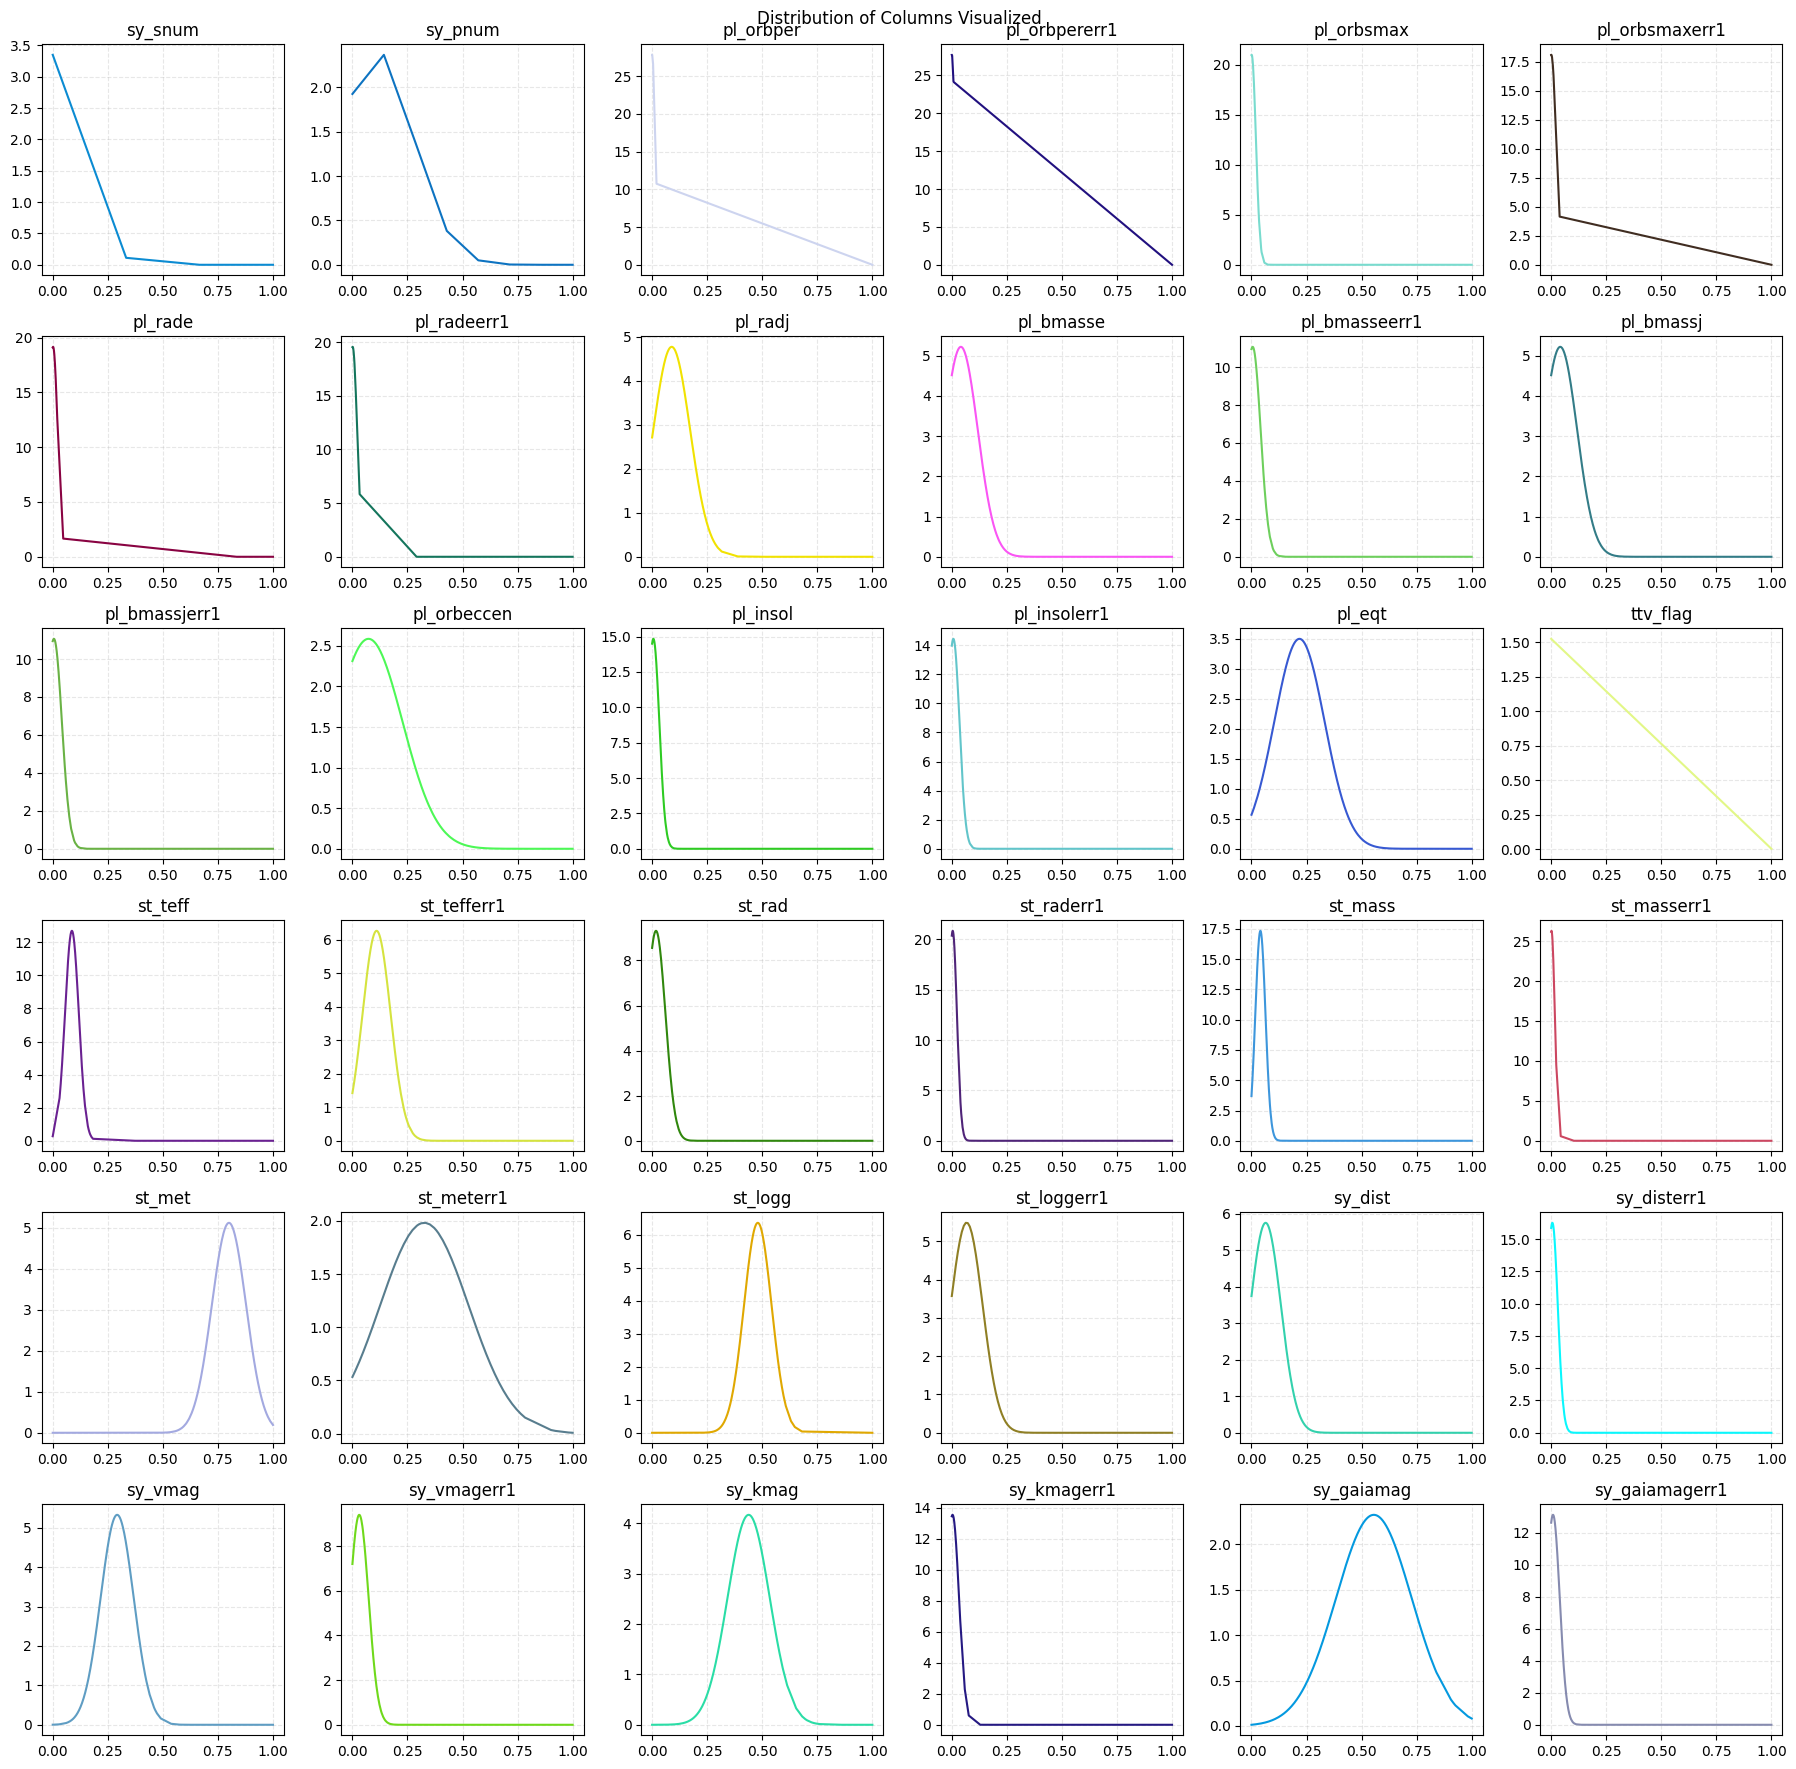

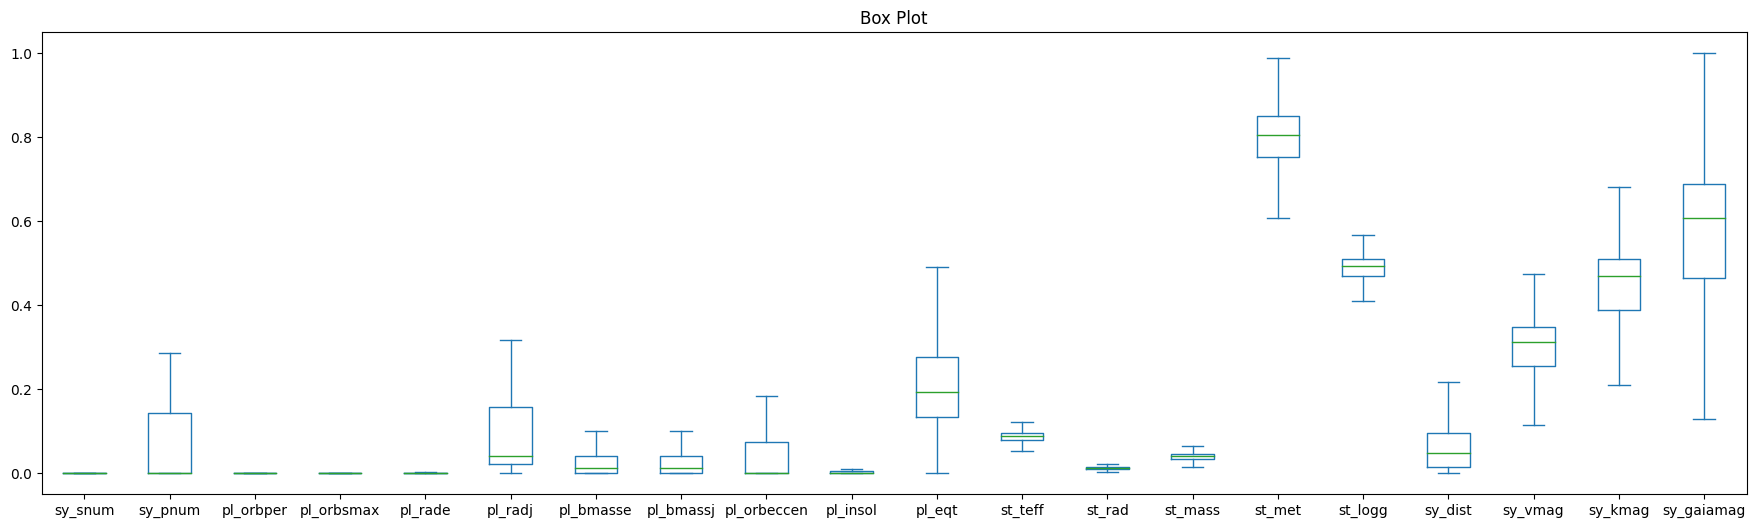

In [259]:
#for col in df.columns:
    #get_col_info(col)

get_cols_info()

The imputation, optimal neighbor is said to be root of N, which is K=70

In [260]:
imputer = KNNImputer(n_neighbors=70)
df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns, index = df.index)

Checking the data after imputation

In [261]:
#df.head(10)

Checking plots after imputation

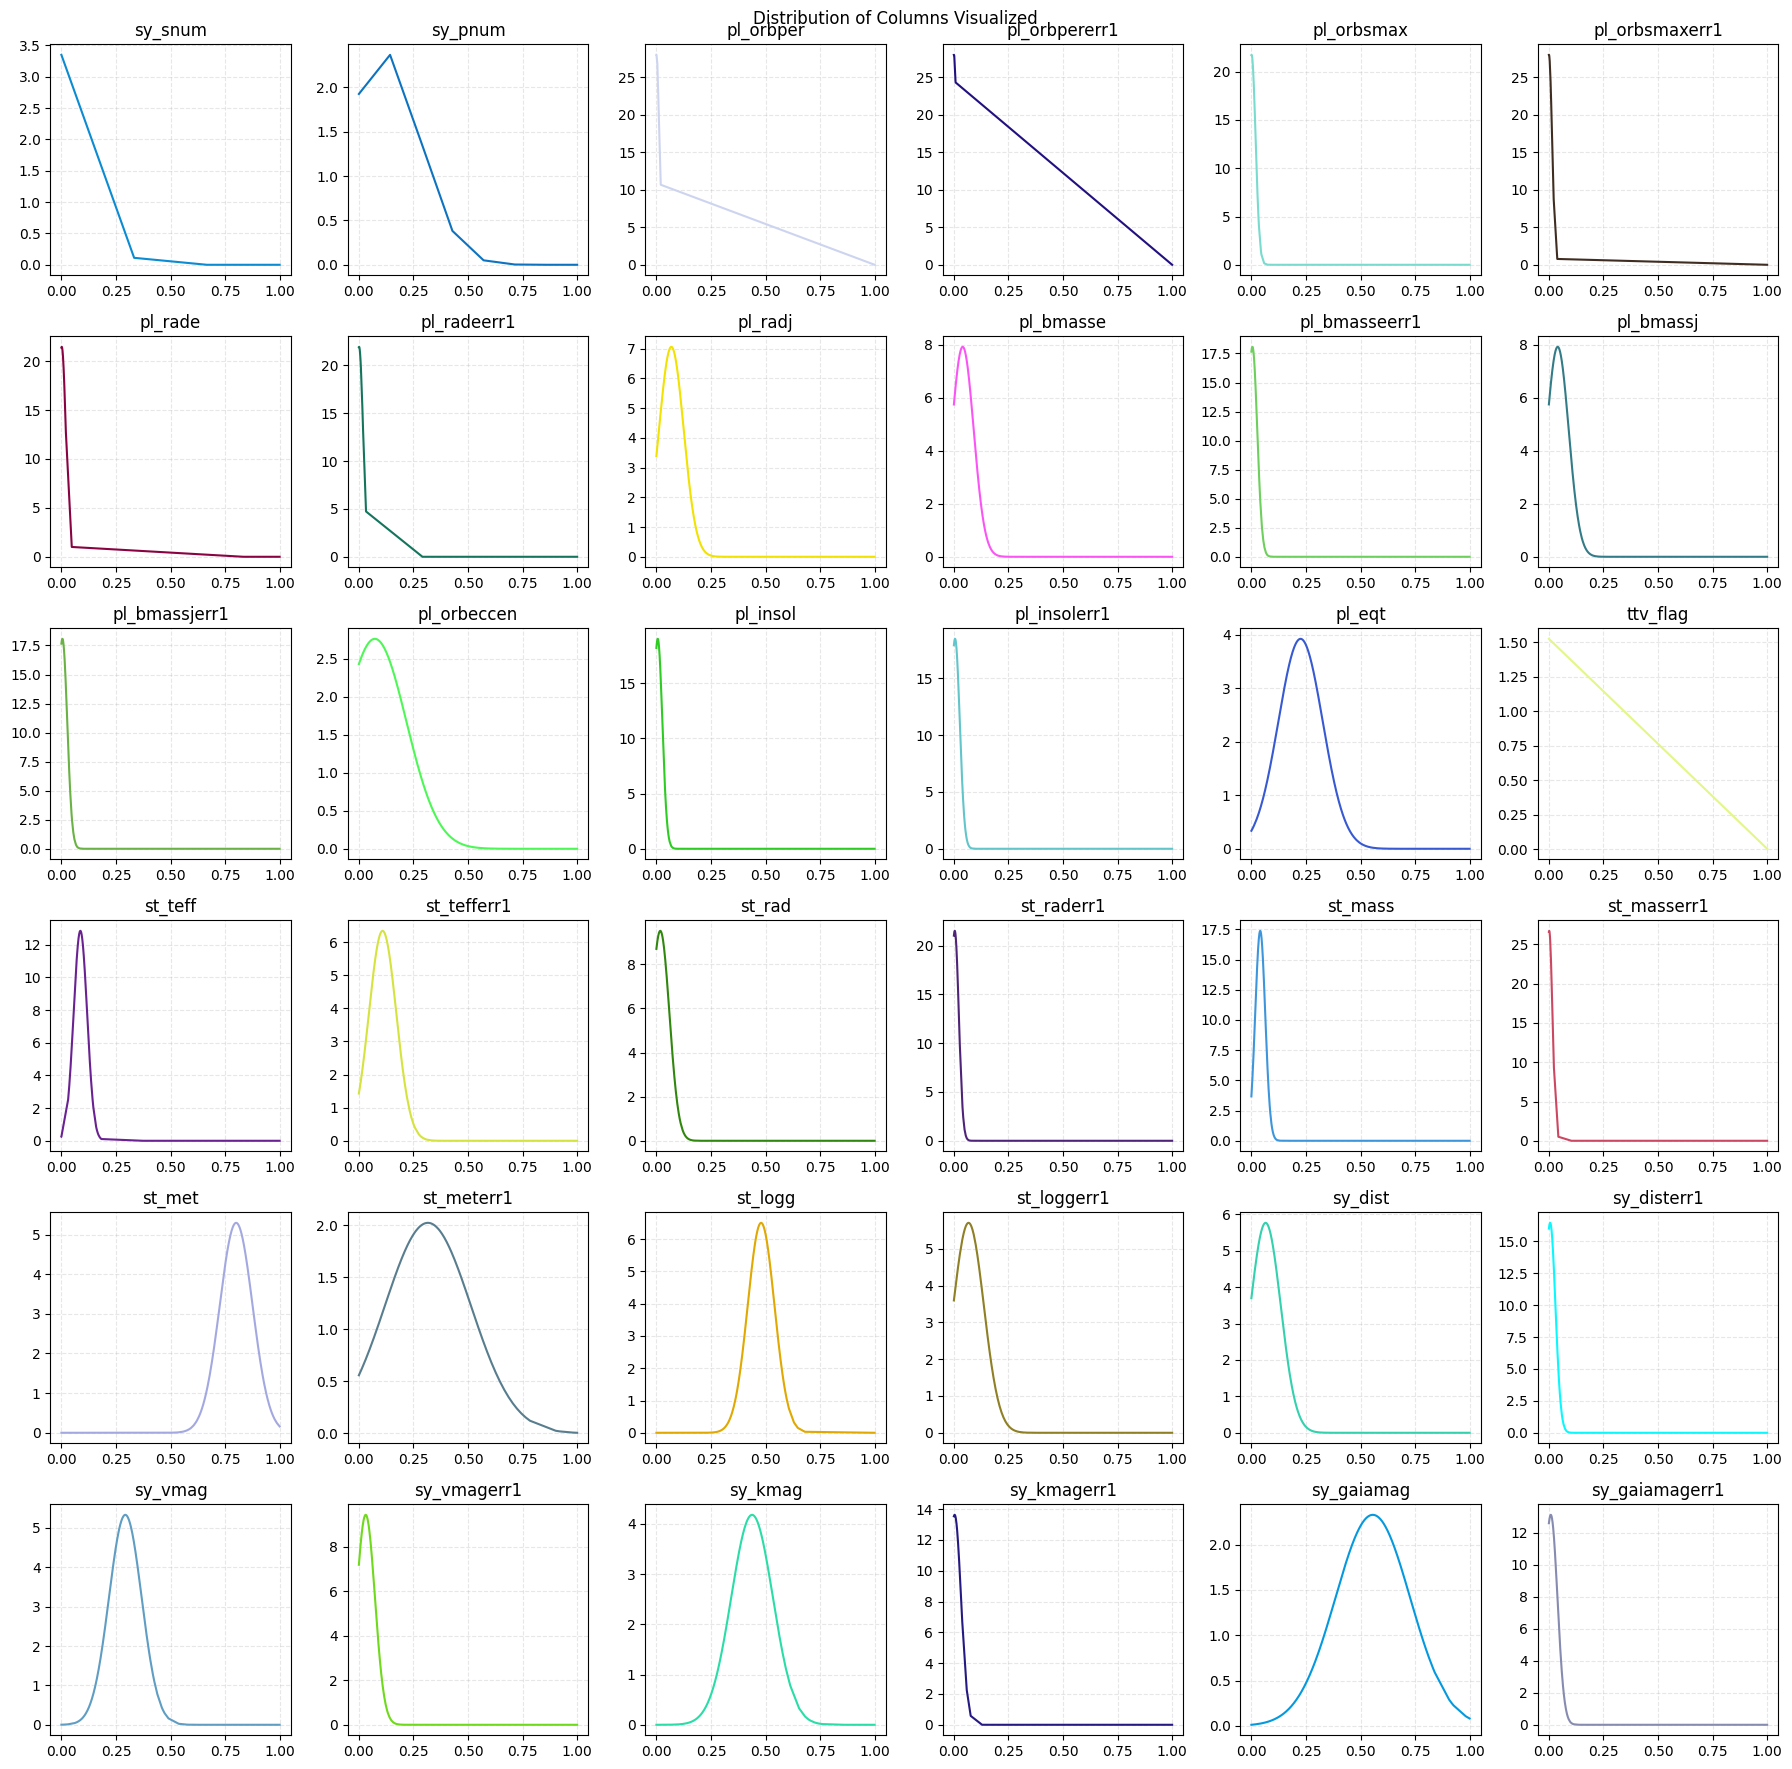

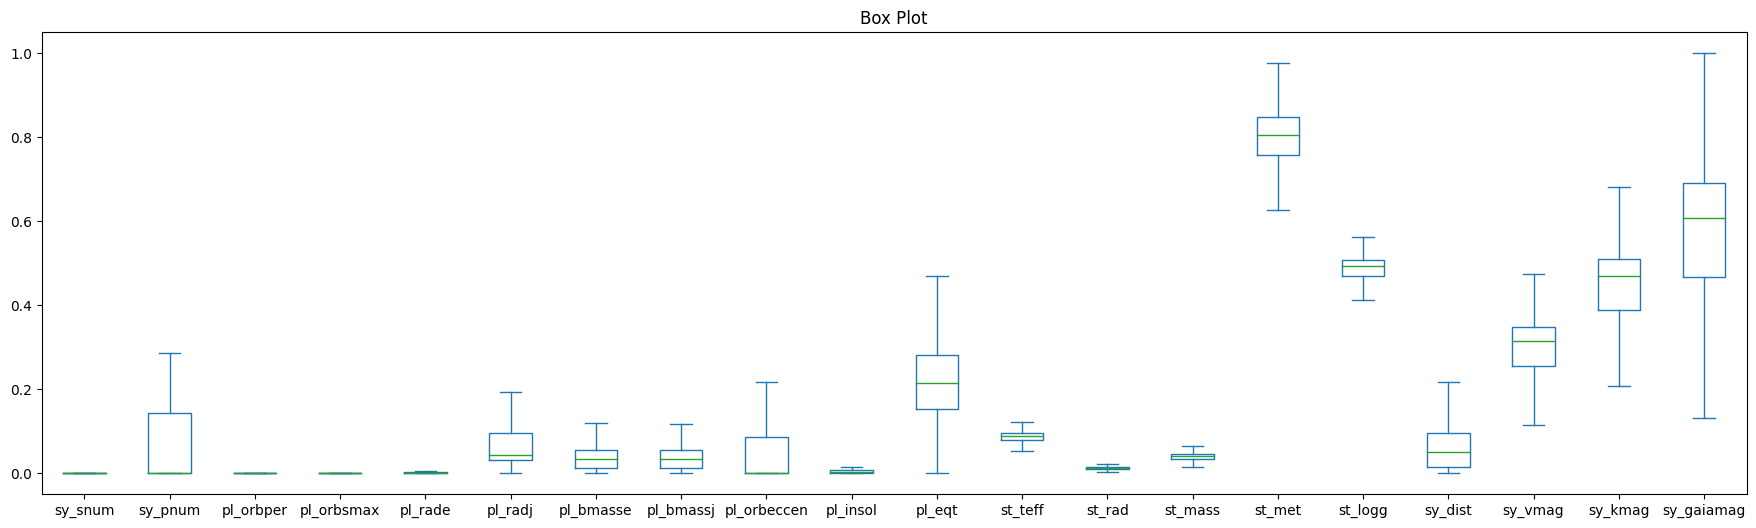

In [262]:
#for col in df.columns:
    #get_col_info(col)
get_cols_info()

Checking null values

In [263]:
df.isna().sum()
df.head()


,sy_snum,sy_pnum,pl_orbper,pl_orbpererr1,pl_orbsmax,pl_orbsmaxerr1,pl_rade,pl_radeerr1,pl_radj,pl_bmasse,...,st_logg,st_loggerr1,sy_dist,sy_disterr1,sy_vmag,sy_vmagerr1,sy_kmag,sy_kmagerr1,sy_gaiamag,sy_gaiamagerr1
0,0.333333,0.000000,8.105728e-07,6.808510e-10,0.000171,0.000010,0.002774,0.000642,0.145104,0.348966,...,0.177419,0.090909,0.010443,0.000517,0.094509,0.006569,0.169975,0.033554,0.087725,0.059038
4,0.000000,0.000000,1.283682e-06,6.914894e-09,0.000204,0.000013,0.002989,0.000680,0.147406,0.188874,...,0.073314,0.136364,0.014095,0.000531,0.101625,0.001194,0.159029,0.025942,0.094780,0.059919
6,0.000000,0.000000,4.618415e-07,4.893617e-10,0.000110,0.000017,0.002418,0.000558,0.122121,0.086341,...,0.224340,0.063636,0.008426,0.000192,0.106983,0.006569,0.171539,0.022937,0.115386,0.042849
7,0.000000,0.142857,4.393608e-06,1.425532e-09,0.000376,0.000008,0.002220,0.000581,0.109308,0.087244,...,0.488270,0.027273,0.001890,0.000002,0.141046,0.006569,0.247590,0.000501,0.200276,0.003632
19,0.666667,0.000000,1.988359e-06,1.276596e-09,0.000223,0.000006,0.002533,0.000391,0.124687,0.030219,...,0.476540,0.090909,0.002255,0.000003,0.131123,0.004479,0.245580,0.000501,0.181810,0.007620


Reverse scaling

In [264]:
#df = pd.DataFrame(scaler.inverse_transform(df), columns = df.columns, index=df.index)
df.head(10)

,sy_snum,sy_pnum,pl_orbper,pl_orbpererr1,pl_orbsmax,pl_orbsmaxerr1,pl_rade,pl_radeerr1,pl_radj,pl_bmasse,...,st_logg,st_loggerr1,sy_dist,sy_disterr1,sy_vmag,sy_vmagerr1,sy_kmag,sy_kmagerr1,sy_gaiamag,sy_gaiamagerr1
0,0.333333,0.000000,8.105728e-07,6.808510e-10,0.000171,9.606148e-06,0.002774,0.000642,0.145104,0.348966,...,0.177419,0.090909,0.010443,0.000517,0.094509,0.006569,0.169975,0.033554,0.087725,0.059038
4,0.000000,0.000000,1.283682e-06,6.914894e-09,0.000204,1.344861e-05,0.002989,0.000680,0.147406,0.188874,...,0.073314,0.136364,0.014095,0.000531,0.101625,0.001194,0.159029,0.025942,0.094780,0.059919
6,0.000000,0.000000,4.618415e-07,4.893617e-10,0.000110,1.693070e-05,0.002418,0.000558,0.122121,0.086341,...,0.224340,0.063636,0.008426,0.000192,0.106983,0.006569,0.171539,0.022937,0.115386,0.042849
7,0.000000,0.142857,4.393608e-06,1.425532e-09,0.000376,7.877041e-06,0.002220,0.000581,0.109308,0.087244,...,0.488270,0.027273,0.001890,0.000002,0.141046,0.006569,0.247590,0.000501,0.200276,0.003632
19,0.666667,0.000000,1.988359e-06,1.276596e-09,0.000223,5.763689e-06,0.002533,0.000391,0.124687,0.030219,...,0.476540,0.090909,0.002255,0.000003,0.131123,0.004479,0.245580,0.000501,0.181810,0.007620
20,0.000000,0.000000,1.438309e-06,4.276596e-09,0.000192,3.842459e-06,0.003032,0.000743,0.149514,0.077710,...,0.087977,0.036364,0.014053,0.000696,0.106853,0.006569,0.163975,0.023337,0.105912,0.078165
21,0.333333,0.000000,2.470448e-06,6.808511e-09,0.000346,2.914791e-05,0.003258,0.000742,0.160836,0.185276,...,0.252199,0.054545,0.008515,0.000167,0.113833,0.006569,0.204570,0.019331,0.136067,0.040119
25,0.000000,0.000000,2.377407e-08,2.517686e-12,0.043964,6.827438e-05,0.000524,0.000197,0.028659,0.169796,...,0.425220,0.127273,0.015665,0.000358,0.288260,0.020305,0.381694,0.001002,0.529028,0.034115
27,0.000000,0.000000,7.505195e-08,1.659572e-11,0.000025,2.305476e-06,0.002397,0.000539,0.121190,0.016369,...,0.193548,0.090909,0.010761,0.000171,0.115785,0.000000,0.197964,0.026943,0.139493,0.029754
28,0.000000,0.142857,1.125921e-06,4.468085e-09,0.000177,7.684918e-07,0.001845,0.000475,0.090893,0.035795,...,0.351906,0.090909,0.008043,0.000184,0.136976,0.006569,0.233899,0.000501,0.189890,0.005952


Check error margins
Some columns have way lower sensivity, thus it was decided to minimalize row termination

In [265]:
field_cols = [
    'pl_orbsmax',
    'pl_bmasse',
    'pl_bmassj',
    'sy_dist',
    'st_teff',
    'st_rad',
    'st_mass',
    'st_met',
    'st_logg',
    'sy_vmag',
    'sy_kmag',
    'sy_gaiamag',
    'pl_rade',
    'pl_orbper',
]

for col in field_cols:
    length = df[df[col +'err1'] / df[col] < 0.5].shape[0]
    print(f'{col} suitable row count: {length}')



pl_orbsmax suitable row count: 3161
pl_bmasse suitable row count: 4856
pl_bmassj suitable row count: 4855
sy_dist suitable row count: 4922
st_teff suitable row count: 600
st_rad suitable row count: 4274
st_mass suitable row count: 4927
st_met suitable row count: 3127
st_logg suitable row count: 4744
sy_vmag suitable row count: 4875
sy_kmag suitable row count: 4925
sy_gaiamag suitable row count: 4862
pl_rade suitable row count: 2897
pl_orbper suitable row count: 4891


Check individual rows and drop whose total error margin is above 50%

A special case is where metallicity is 0, it must not be zero thus half of the error margin is added to the value in order to fix the problem

In [266]:
overall_error_margins = {i:0 for i in df.index}
for i in df.index:
    for col in field_cols:
        if df[col][i] == 0:
            df[col][i] = df[col + 'err1'][i] / 2
            overall_error_margins[i] = (overall_error_margins[i] + df[col][i]) / 2
        else:
            margin = df[col + 'err1'][i] / df[col][i]
            overall_error_margins[i] = (overall_error_margins[i] + margin) / 2

for k,v in overall_error_margins.items():
    if v > 0.5:
        df.drop(i, axis = 'rows')


Dropping the error margin columns

In [267]:
df = df.drop(columns=[col + 'err1' for col in field_cols])

Scale again before proceeding to elbow method

In [268]:
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns, index=df.index)
df.head(10)

,sy_snum,sy_pnum,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,pl_bmassj,pl_orbeccen,pl_insol,...,ttv_flag,st_teff,st_rad,st_mass,st_met,st_logg,sy_dist,sy_vmag,sy_kmag,sy_gaiamag
0,0.333333,0.000000,8.105728e-07,0.000171,0.002763,0.145104,0.348966,0.348983,0.250814,0.019658,...,0.0,0.073760,0.226638,0.114225,0.597345,0.165179,0.010443,0.091525,0.164578,0.085499
4,0.000000,0.000000,1.283682e-06,0.000204,0.002978,0.147406,0.188874,0.188882,0.086862,0.007888,...,0.0,0.066635,0.287266,0.076008,0.769912,0.059524,0.014095,0.098664,0.153560,0.092572
6,0.000000,0.000000,4.618415e-07,0.000110,0.002407,0.122121,0.086341,0.086345,0.000000,0.008679,...,0.0,0.075018,0.131161,0.092994,0.646018,0.212798,0.008426,0.104040,0.166152,0.113227
7,0.000000,0.142857,4.393608e-06,0.000376,0.002209,0.109308,0.087244,0.087245,0.398914,0.004890,...,0.0,0.083915,0.011815,0.040764,0.931416,0.480655,0.001890,0.138216,0.242698,0.198325
19,0.666667,0.000000,1.988359e-06,0.000223,0.002522,0.124687,0.030219,0.030220,0.748100,0.007675,...,0.0,0.091573,0.013367,0.043312,0.778761,0.468750,0.002255,0.128260,0.240674,0.179814
20,0.000000,0.000000,1.438309e-06,0.000192,0.003021,0.149514,0.077710,0.077711,0.065147,0.007749,...,0.0,0.063391,0.309225,0.051380,0.747788,0.074405,0.014053,0.103910,0.158539,0.103730
21,0.333333,0.000000,2.470448e-06,0.000346,0.003247,0.160836,0.185276,0.185284,0.086862,0.010599,...,0.0,0.077961,0.101325,0.097240,0.729204,0.241071,0.008515,0.110913,0.199398,0.133959
25,0.000000,0.000000,2.377407e-08,0.043964,0.000513,0.028659,0.169796,0.143910,0.062494,0.021936,...,0.0,0.060484,0.015515,0.025902,0.744014,0.416667,0.015665,0.285914,0.377674,0.527879
27,0.000000,0.000000,7.505195e-08,0.000025,0.002386,0.121190,0.016369,0.016369,0.045603,0.007481,...,0.0,0.076436,0.126865,0.041614,0.411504,0.181548,0.010761,0.112871,0.192749,0.137394
28,0.000000,0.142857,1.125921e-06,0.000177,0.001834,0.090893,0.035795,0.035797,0.097720,0.005288,...,0.0,0.080070,0.058360,0.064968,0.738938,0.342262,0.008043,0.134132,0.228918,0.187913


<h1> Optimizing Clustering Method </h1>

Calculate inertias and distortions for elbow method

In [269]:
distortions = []
inertias = []
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, n_init='auto').fit(df)
    kmeanModel.fit(df)
    distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / df.shape[0])
    inertias.append(kmeanModel.inertia_)

Plotting the distortions

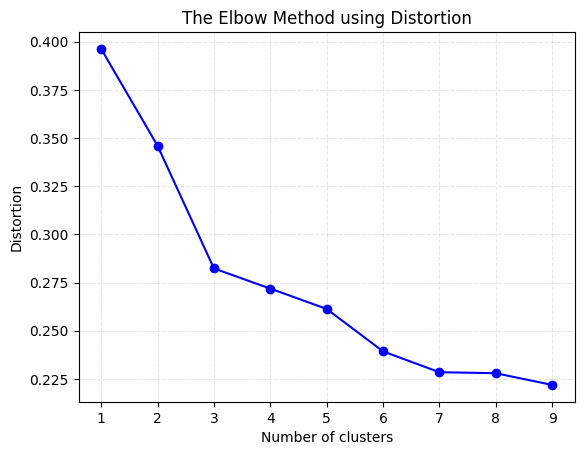

In [270]:
plt.plot(K, distortions, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.grid(True, alpha=0.3, linestyle="--")
plt.show()

Plotting Intertias

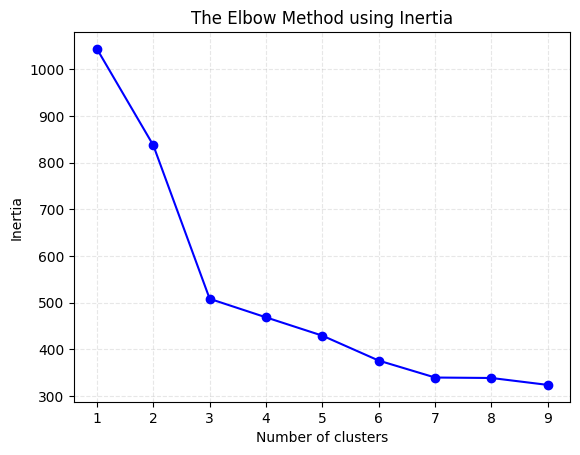

In [271]:
plt.plot(K, inertias, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.grid(True, alpha=0.3, linestyle="--")
plt.show()